In [2]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Load the graph
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    
    print(nx.info(train_graph))
else:
    print("Please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
#Get feature information
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

## 1.0 Preferential Attachment:

1. https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_prediction.preferential_attachment.html
2. http://be.amazd.com/link-prediction/
3. D. Liben-Nowell, J. Kleinberg. The Link Prediction Problem for Social Networks (2004). http://www.cs.cornell.edu/home/kleinber/link-pred.pdf

<b>Preferential Attachment</b>: One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how "rich" our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity. 

In [5]:
#Preferential attachment for followees
def prefer_attach_followees(a,b):
    try:
        if (len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0):
            return 0
        else:
            pa_score = len(set(train_graph.successors(a))) * len(set(train_graph.successors(b)))
    except:
        return 0
    return pa_score

In [6]:
prefer_attach_followees(832016, 1543415)

8662

In [7]:
#Preferential attachment for followees
def prefer_attach_followers(a,b):
    try:
        if (len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0):
            return 0
        else:
            pa_score = len(set(train_graph.predecessors(a))) * len(set(train_graph.predecessors(b)))
    except:
        return 0
    return pa_score

In [8]:
prefer_attach_followers(832016, 1543415)

1598

### Adding the new preferential attachment features to the dataset

In [9]:
#Adding features to train data
df_final_train['pref_attach_followees'] = df_final_train.apply(lambda row: prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)
df_final_train['pref_attach_followers'] = df_final_train.apply(lambda row: prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)

In [10]:
#Adding features to test data
df_final_test['pref_attach_followees'] = df_final_test.apply(lambda row: prefer_attach_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attach_followers'] = df_final_test.apply(lambda row: prefer_attach_followers(row['source_node'],row['destination_node']),axis=1)

In [11]:
df_final_train[['pref_attach_followees','pref_attach_followers']].head()

,pref_attach_followees,pref_attach_followers
0,120,66
1,8662,1598
2,902,980
3,35,22
4,33,5


In [12]:
df_final_test[['pref_attach_followees','pref_attach_followers']].head()

,pref_attach_followees,pref_attach_followers
0,54,84
1,19,34
2,144,150
3,340,407
4,405,324


In [13]:
len(df_final_test.columns)

56

## 2. SVD Dot

<b>We have already computed the 12 dimensional SVD features (6D for source and 6D for destination). 12 dimensions each for both right as well as left singular matrix. We will now do a dot product of the SVD features of both source and destination for both the right as well as left singular matrices, and also for both train and test data</b>

In [14]:
#This function will compute the dot product between source svd(6D) and destination svd(6D)
def svd_dot(svd):
    svd_dot_list=[]
    for index, row in tqdm(svd.iterrows()):
        svd_source = row[0:6].values
        svd_dest = row[6:12].values
        svd_dot = np.dot(svd_source,svd_dest)
        svd_dot_list.append(svd_dot)
    return svd_dot_list

### Adding the new SVD dot features to the dataset

In [15]:
#SVD values for U, for train data
svd_u = df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]
df_final_train['svd_dot_u']=svd_dot(svd_u)

100002it [00:18, 5303.92it/s]


In [16]:
#SVD values for v, for train data
svd_v = df_final_train[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]
df_final_train['svd_dot_v']=svd_dot(svd_v)

100002it [00:18, 5328.08it/s]


In [17]:
#SVD values for U, for test data
svd_u = df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]
df_final_test['svd_dot_u']=svd_dot(svd_u)

50002it [00:09, 5308.69it/s]


In [18]:
#SVD values for v, for test data
svd_v = df_final_test[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]
df_final_test['svd_dot_v']=svd_dot(svd_v)

50002it [00:09, 5301.38it/s]


In [21]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attach_followees', 'pref_attach_followers', 'svd_dot_u',
       'svd_dot_v'],
      dtype='object')

In [22]:
df_final_train.to_csv("data/df_final_train_feature_engineered.csv", index=None)
df_final_test.to_csv("data/df_final_test_feature_engineered.csv", index=None)

### Applying Machine Learning models on the final set of features

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#### 1. Load the feature engineered dataset

In [3]:
#Independent variables
df_final_train=pd.read_csv("data/df_final_train_feature_engineered.csv")
df_final_test=pd.read_csv("data/df_final_test_feature_engineered.csv")

In [4]:
#Target variables
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [5]:
#Drop the unwanted features + the target variable
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

#### 2. Apply Random Forest Classifier

Estimators =  10 Train F1 Score 0.9247145749410366 Test F1 Score 0.9070220790778489
Estimators =  50 Train F1 Score 0.9202873688697587 Test F1 Score 0.9065528622784703
Estimators =  100 Train F1 Score 0.9205365064453838 Test F1 Score 0.9153941222061627
Estimators =  250 Train F1 Score 0.9207252044081052 Test F1 Score 0.913255647637878
Estimators =  450 Train F1 Score 0.9213715791565144 Test F1 Score 0.9140608560245782
Estimators =  750 Train F1 Score 0.9218091503267974 Test F1 Score 0.9147812177719782
Estimators =  1000 Train F1 Score 0.922095176324131 Test F1 Score 0.9150037888355647
Estimators =  1500 Train F1 Score 0.9218124209183406 Test F1 Score 0.9144793618051316
Estimators =  2000 Train F1 Score 0.9220436856640722 Test F1 Score 0.9146526315789474


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

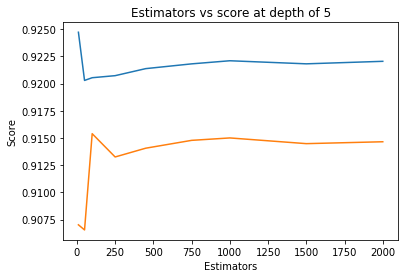

In [11]:
#In this block we are tuning only the number of estimators.
estimators = [10,50,100,250,450,750,1000,1500,2000]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train F1 Score',train_sc,'Test F1 Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

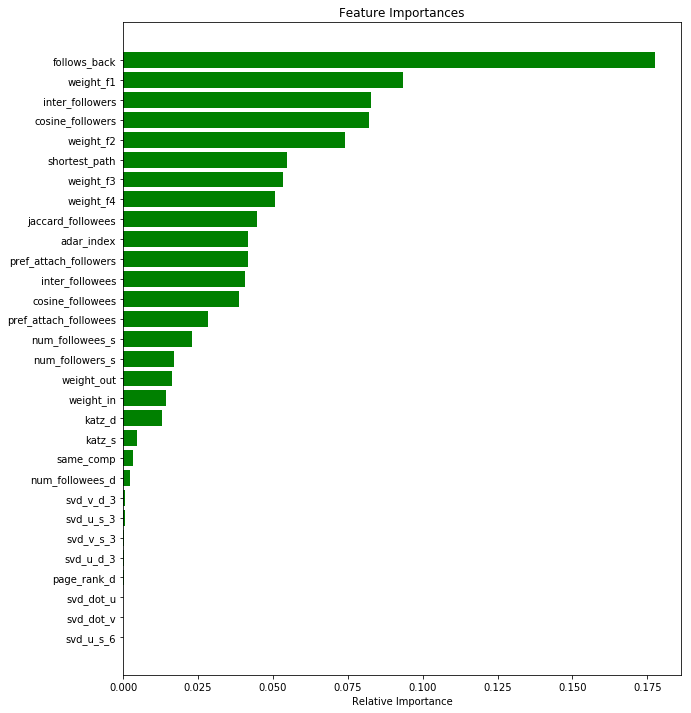

In [16]:
#Get feature importances
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Depth =  3 Train F1 Score 0.9097409508457588 Test F1 Score 0.8861138650410276
Depth =  9 Train F1 Score 0.9586007375262311 Test F1 Score 0.9233071297603743
Depth =  11 Train F1 Score 0.9620353443022547 Test F1 Score 0.9254529004565826
Depth =  15 Train F1 Score 0.96287804234683 Test F1 Score 0.9255030593578503
Depth =  20 Train F1 Score 0.9635026141936529 Test F1 Score 0.9256746823479995
Depth =  35 Train F1 Score 0.9633638381320118 Test F1 Score 0.9254490074571998
Depth =  50 Train F1 Score 0.9633638381320118 Test F1 Score 0.9254490074571998
Depth =  70 Train F1 Score 0.9633638381320118 Test F1 Score 0.9254490074571998
Depth =  130 Train F1 Score 0.9633638381320118 Test F1 Score 0.9254490074571998


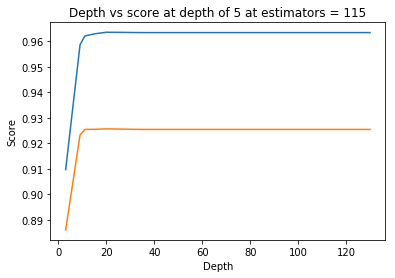

In [18]:
#Tune the depth
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train F1 Score',train_sc,'Test F1 Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

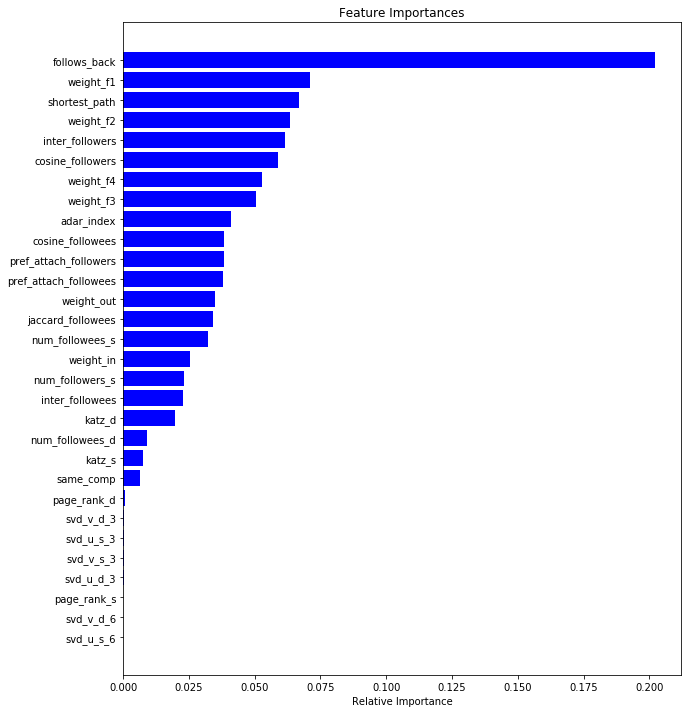

In [20]:
#Get feature importances
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Hyper-parameter tuning using Random Search CV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=10,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('Mean test scores: ',rf_random.cv_results_['mean_test_score'])
print('Mean train scores: ',rf_random.cv_results_['mean_train_score'])

In [ ]:
#Print the best estimator
print(rf_random.best_estimator_)

In [ ]:
#Train a model with the best estimator obtained using random search
clf=rf_random.best_estimator_

clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
#Plot the confusion matrix for train and test data
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [ ]:
#Plot ROC Curve for the best model obtained using random Search
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()